In [57]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
df = pd.read_csv("TCGA.STAD.mutations.txt", sep="\t")



In [59]:
print(mutation_counts.columns.tolist())
# Count mutations per patient
mutation_counts = df['patient_id'].value_counts().sort_index()



AttributeError: 'Series' object has no attribute 'columns'

Log10 split: 2.858
Exact split: 721 mutations


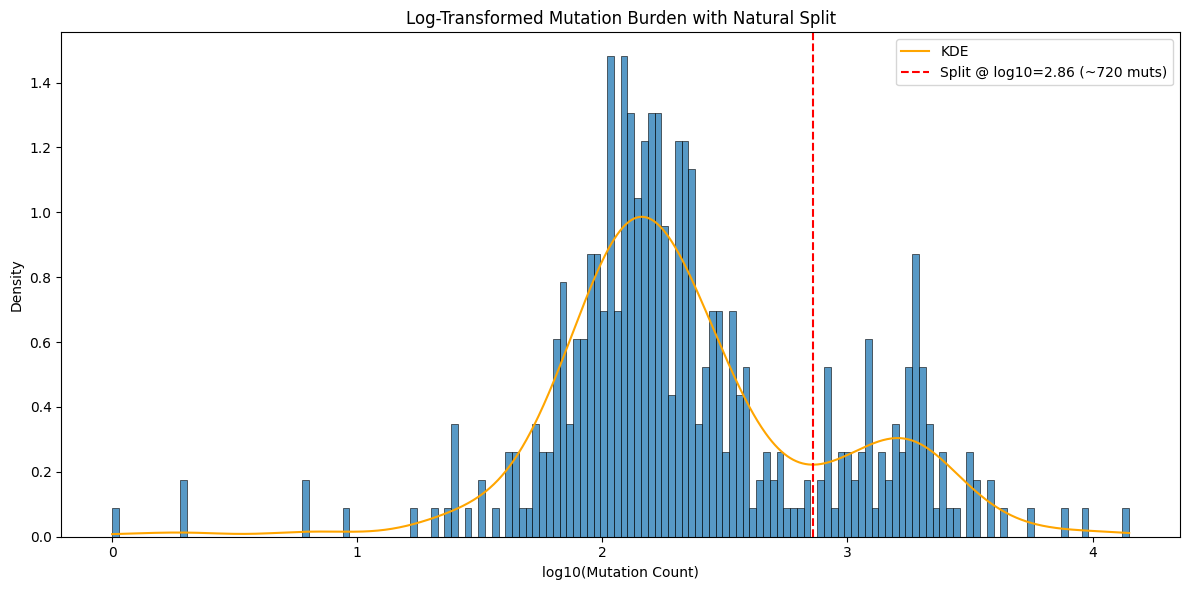

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks

# Get mutation counts > 0
counts_array = mutation_counts[mutation_counts > 0].values.astype(float)
log_counts = np.log10(counts_array)

# KDE
kde = gaussian_kde(log_counts)
x_vals = np.linspace(log_counts.min(), log_counts.max(), 1000)
kde_vals = kde(x_vals)

# Restrict search to real bimodal region (log10 ≈ 1.5 to 3.5)
mask = (x_vals > 1.5) & (x_vals < 3.5)
x_zoom = x_vals[mask]
kde_zoom = kde_vals[mask]

# Find trough (local minimum)
troughs, _ = find_peaks(-kde_zoom)
if len(troughs) > 0:
    log_split = x_zoom[troughs[0]]
    exact_split = 10**log_split
    print(f"Log10 split: {log_split:.3f}")
    print(f"Exact split: {exact_split:.0f} mutations")
else:
    log_split = None
    print("No trough found.")

# Plot
plt.figure(figsize=(12, 6))
sns.histplot(log_counts, bins=150, kde=False, stat="density")
plt.plot(x_vals, kde_vals, color='orange', label='KDE')

# Plot vertical line for the split
if log_split:
    plt.axvline(log_split, color='red', linestyle='--', label=f"Split @ log10={log_split:.2f} (~{int(exact_split)} muts)")

plt.xlabel("log10(Mutation Count)")
plt.ylabel("Density")
plt.title("Log-Transformed Mutation Burden with Natural Split")
plt.legend()
plt.tight_layout()
plt.show()


In [52]:
# Get histogram bin edges from the KDE-aligned plot
hist_bins = np.histogram_bin_edges(log_counts, bins=50)

# Convert log bins to linear mutation counts
linear_bins = 10 ** hist_bins

# Find the largest bin edge that is still less than the exact split
bin_aligned_split = linear_bins[linear_bins < exact_split].max()

print(f"Adjusted split (previous bin edge): {bin_aligned_split:.0f} mutations")


Adjusted split (previous bin edge): 663 mutations


In [61]:
# Threshold based on natural split
threshold = 663  # or use int(exact_split) from your earlier KDE step

# Create mutation count dataframe
mutation_counts = df['patient_id'].value_counts().sort_index()
mutation_split_df = mutation_counts.to_frame(name="mutation_count")

# Assign groups
mutation_split_df["mutation_group"] = mutation_split_df["mutation_count"].apply(
    lambda x: "High" if x >= threshold else "Low"
)

# Split into patient ID lists
low_patients = mutation_split_df[mutation_split_df["mutation_group"] == "Low"].index.tolist()
high_patients = mutation_split_df[mutation_split_df["mutation_group"] == "High"].index.tolist()

# Filter original mutation rows
low_mut = df[df['patient_id'].isin(low_patients)]
high_mut = df[df['patient_id'].isin(high_patients)]

# Build mutation matrix
def build_mutation_matrix(df, context_col="CONTEXT", sample_col="patient_id"):
    mutation_matrix = (
        df.groupby([sample_col, context_col])
        .size()
        .unstack(fill_value=0)
        .sort_index()
    )
    return mutation_matrix

# Create the matrices
low_matrix = build_mutation_matrix(low_mut)
high_matrix = build_mutation_matrix(high_mut)


In [ ]:
# Align both series to same context index
all_contexts = sorted(set(low_matrix.columns).union(set(high_matrix.columns)))

low_sum = low_matrix.reindex(columns=all_contexts, fill_value=0).sum(axis=0)
high_sum = high_matrix.reindex(columns=all_contexts, fill_value=0).sum(axis=0)

# Normalize
low_norm = low_sum / low_sum.sum()
high_norm = high_sum / high_sum.sum()

# Plot
fig, ax = plt.subplots(figsize=(14, 5))
width = 0.4
x = np.arange(len(all_contexts))

ax.bar(x - width/2, low_norm.values, width=width, label='Low burden')
ax.bar(x + width/2, high_norm.values, width=width, label='High burden')

ax.set_xticks(x)
ax.set_xticklabels(all_contexts, rotation=90)
ax.set_ylabel("Proportion")
ax.set_title("Trinucleotide Mutation Context Spectrum")
ax.legend()
plt.tight_layout()
plt.show()


/var/folders/7s/vcvt681x3bn3b33blcfj30zr0000gn/T/ipykernel_66780/1959461518.py:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


In [ ]:
from sklearn.decomposition import NMF

# Choose matrix: low or high
X = high_matrix.values  # or low_matrix.values
model = NMF(n_components=2, init='nndsvd', random_state=0, max_iter=1000)
W = model.fit_transform(X)  # patient × signature
H = model.components_       # signature × context

# Plot signatures
plt.figure(figsize=(12, 4))
for i, row in enumerate(H):
    plt.subplot(1, H.shape[0], i + 1)
    plt.bar(range(len(row)), row)
    plt.title(f'Signature {i+1}')
    plt.xticks(range(len(row)), high_matrix.columns, rotation=90)
    plt.tight_layout()
